In [2]:
!git clone https://github.com/Tanveer2719/NIDS_Coursework.git
%cd /kaggle/working/NIDS_Coursework/My_Code

Cloning into 'NIDS_Coursework'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 242 (delta 123), reused 203 (delta 84), pack-reused 0 (from 0)
Receiving objects: 100% (242/242), 202.03 KiB | 3.37 MiB/s, done.
Resolving deltas: 100% (123/123), done.
/kaggle/working/NIDS_Coursework/My_Code


In [3]:
!ls /kaggle/input

pgd_trained_with_random_epsilon  unsw-nb-15


In [4]:
import os
import random
import numpy as np
import tensorflow as tf

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seed(42)


In [5]:
import pandas as pd
import numpy as np

path = "/kaggle/input/unsw-nb-15/UNSW-NB15_combined.csv"

df = pd.read_csv(path)

print(df.shape)
df = df.drop(columns=['id', 'label'])
print(df.shape)

print(f"🧾 Unique class labels: {df['attack_cat'].unique()}")
df['label'] = df['attack_cat'].apply(lambda x: 0 if x == 'Normal' else 1)

print(f'Unique values for label {df["label"].unique()}')

df = df.drop(columns=["attack_cat"])
print(f'new shape{df.shape}')



# --------------------------- perform preprocessing--------------

from preprocess import Preprocess

# separate the features and labels so that the labesl are not encoded
labels = df['label']
features = df.drop(columns=['label'])

pp = Preprocess()
processed_features = pp.fit_transform_df_auto(df = features,n_categorical_levels=32, expected_categorical_format='onehot')

print(processed_features.shape)

# concat the features and the labels
processed_full_df = pd.concat([processed_features, labels], axis=1)


(257673, 45)
(257673, 43)
🧾 Unique class labels: ['Normal' 'Backdoor' 'Analysis' 'Fuzzers' 'Shellcode' 'Reconnaissance'
 'Exploits' 'DoS' 'Worms' 'Generic']
Unique values for label [0 1]
new shape(257673, 43)
Encoding the 32 levels for proto
Encoding the 13 levels for service
Encoding the 11 levels for state
(257673, 95)


In [6]:
# Filter out categorical one-hot encoded columns
numerical_columns = [col for col in processed_full_df 
                     if not (col.startswith("proto_") or 
                             col.startswith("service_") or 
                             col.startswith("state_") or
                             col == 'label')]



In [7]:
target = processed_full_df['label']
features = processed_full_df.drop(columns=['label'])

In [8]:
from record_level_embedding import RecordLevelEmbedder

embedder = RecordLevelEmbedder(selected_df = features, numerical_columns = numerical_columns, embed_dimension= 64)

embedded_df = embedder.transform_to_df()
embedded_df.head()

[INFO] Initializing RecordLevelEmbedder...
[INFO] Detecting categorical blocks...
[INFO] Detected 3 categorical blocks:
   - proto: 32 columns
   - service: 13 columns
   - state: 11 columns
[INFO] Embedder initialized with embedding dimension 64.
[INFO] Building Keras embedding model...
   - Adding numerical input: dur
   - Adding numerical input: spkts
   - Adding numerical input: dpkts
   - Adding numerical input: sbytes
   - Adding numerical input: dbytes
   - Adding numerical input: rate
   - Adding numerical input: sttl
   - Adding numerical input: dttl
   - Adding numerical input: sload
   - Adding numerical input: dload
   - Adding numerical input: sloss
   - Adding numerical input: dloss
   - Adding numerical input: sinpkt
   - Adding numerical input: dinpkt
   - Adding numerical input: sjit
   - Adding numerical input: djit
   - Adding numerical input: swin
   - Adding numerical input: stcpb
   - Adding numerical input: dtcpb
   - Adding numerical input: dwin
   - Adding nume

I0000 00:00:1753721887.568197      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753721887.568899      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


[INFO] Projection complete. Output embedding shape: (64,)
[INFO] Model build complete.
[INFO] Preparing inputs for embedding. Number of rows: 257673
   - Prepared numerical input: dur
   - Prepared numerical input: spkts
   - Prepared numerical input: dpkts
   - Prepared numerical input: sbytes
   - Prepared numerical input: dbytes
   - Prepared numerical input: rate
   - Prepared numerical input: sttl
   - Prepared numerical input: dttl
   - Prepared numerical input: sload
   - Prepared numerical input: dload
   - Prepared numerical input: sloss
   - Prepared numerical input: dloss
   - Prepared numerical input: sinpkt
   - Prepared numerical input: dinpkt
   - Prepared numerical input: sjit
   - Prepared numerical input: djit
   - Prepared numerical input: swin
   - Prepared numerical input: stcpb
   - Prepared numerical input: dtcpb
   - Prepared numerical input: dwin
   - Prepared numerical input: tcprtt
   - Prepared numerical input: synack
   - Prepared numerical input: ackdat
  

2025-07-28 16:58:09.638340: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_55}}


8053/8053 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step
[INFO] Embedding complete. Output shape: (257673, 64)
[INFO] Embedding DataFrame ready.


,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_54,embed_55,embed_56,embed_57,embed_58,embed_59,embed_60,embed_61,embed_62,embed_63
0,0.526297,-0.274962,0.240046,0.175640,0.319582,0.166146,-0.400173,0.299557,-0.278061,-0.367071,...,0.239632,-0.532777,0.342142,0.636009,0.142315,0.567157,-0.027547,0.675332,0.262451,-0.256291
1,0.446926,-0.485022,0.346259,0.323633,0.321390,0.201763,-0.330970,0.181381,-0.308502,-0.448172,...,0.333167,-0.426263,0.119546,0.955216,-0.144012,0.463430,-0.061751,0.865791,0.051590,-0.186757
2,0.574880,-0.415946,0.315918,0.423030,0.160432,0.121868,-0.391887,0.107925,-0.385792,-0.428478,...,0.336697,-0.537757,0.248757,0.903345,0.011872,0.414185,-0.086681,0.946179,0.125380,-0.186142
3,0.474340,-0.401083,-0.002091,0.195434,0.070202,0.130771,-0.279687,0.358879,-0.355054,-0.178992,...,0.552881,-0.559983,0.277592,0.439648,-0.015634,0.402661,0.120276,0.912281,0.175457,-0.361705
4,0.303137,-0.440379,0.407369,0.260833,0.161380,0.143277,-0.447615,-0.045396,-0.068655,-0.548605,...,0.326617,-0.793486,0.250744,1.014336,-0.177306,0.366739,-0.051078,1.076557,0.044510,-0.218280


In [12]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

print(processed_full_df['label'].unique())

binary_target = (processed_full_df['label'] != 0).astype(int).values
unique, counts = np.unique(binary_target, return_counts=True)
print("Classes and their counts:")
for cls, cnt in zip(unique, counts):
    print(f"Class {cls}: {cnt}")

X_embed = embedded_df.values.astype(np.float32)  # shape: (num_samples, input_dim)
X_embed_seq = tf.expand_dims(X_embed, axis=1)  # shape: (batch_size, 1, embed_dim)
print(f"X_embed_seq : {X_embed_seq.shape}")

X_np = X_embed_seq.numpy() if hasattr(X_embed_seq, 'numpy') else np.array(X_embed_seq)

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X_np, binary_target, test_size=0.2, stratify=binary_target, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")


[0 1]
Classes and their counts:
Class 0: 93000
Class 1: 164673
X_embed_seq : (257673, 1, 64)
X_train: (164910, 1, 64)
y_train: (164910,)
X_val: (41228, 1, 64)
y_val: (41228,)
X_test: (51535, 1, 64)
y_test: (51535,)


## FlowTransformer

In [14]:
# -------------------------Model Train----------------
import tensorflow as tf
from transformer import BasicTransformer
from classification import LastTokenClassificationHead
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


# input data
X_embed = embedded_df.values                   # shape: (num_samples, embed_dim)
X_embed_seq = tf.expand_dims(X_embed, axis=1)  # shape: (batch_size, 1, embed_dim)

input_layer = Input(shape=(1, X_embed.shape[1]), name="record_input")

# Create transformer
transformer = BasicTransformer(
    n_layers=2,
    internal_size=128,
    n_heads=4,
    verbose=False  # See progress!
)


x = transformer.apply(input_layer, training=True)


# Create head
classification_head = LastTokenClassificationHead()

# Pool last token
x = classification_head.apply(x)

#  Add MLP head  
for i, layer_size in enumerate([128]):
    x = Dense(layer_size, activation="relu", name=f"classification_mlp_{i}_{layer_size}")(x)
    x = Dropout(0.1)(x)

#  output layer for binary classification
output_layer = Dense(1, activation="sigmoid", name="binary_output")(x)

# Build model  
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

# Compile model 
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
    jit_compile=True
)

# Define early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=0
)

# Train the model
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ record_input (InputLayer)       │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_0_transformer_encoder     │ (None, 1, 64)          │       149,504 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_1_transformer_encoder     │ (None, 1, 64)          │       149,504 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ slice_last (Lambda)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_mlp_0_128        │ (None, 128)            │         8,320 │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ binary_output (Dense)           │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,457 (1.17 MB)

 Trainable params: 307,457 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(
2025-07-28 17:17:19.330743: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


5154/5154 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8974 - loss: 0.2059

2025-07-28 17:18:32.704330: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


5154/5154 ━━━━━━━━━━━━━━━━━━━━ 78s 13ms/step - accuracy: 0.8974 - loss: 0.2059 - val_accuracy: 0.9102 - val_loss: 0.1715
Epoch 2/20
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.9148 - loss: 0.1687 - val_accuracy: 0.9223 - val_loss: 0.1610
Epoch 3/20
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.9197 - loss: 0.1618 - val_accuracy: 0.9197 - val_loss: 0.1604
Epoch 4/20
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.9229 - loss: 0.1568 - val_accuracy: 0.9239 - val_loss: 0.1584
Epoch 5/20
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - accuracy: 0.9246 - loss: 0.1529 - val_accuracy: 0.9250 - val_loss: 0.1499
Epoch 6/20
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.9255 - loss: 0.1510 - val_accuracy: 0.9260 - val_loss: 0.1468
Epoch 7/20
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.9269 - loss: 0.1475 - val_accuracy: 0.9110 - val_loss: 0.1816
Epoch 8/20
5154/5154 ━━━━━━━━━━━━━━━━━━━━ 67s 13ms/step - accuracy: 0.9285 - loss: 0.14

## GAN

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class Generator(Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = layers.Conv1D(64, kernel_size=1, padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv1D(128, kernel_size=1, padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv1D(64, kernel_size=1, padding='same', activation='relu')
        self.bn3 = layers.BatchNormalization()
        self.output_layer = layers.Conv1D(64, kernel_size=1, padding='same', activation='linear')

    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.conv3(x)
        x = self.bn3(x, training=training)
        return self.output_layer(x)
        
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = layers.Conv1D(64, kernel_size=1, activation='relu', padding='same')
        self.global_pool = layers.GlobalAveragePooling1D()
        self.dense1 = layers.Dense(64, activation='relu')
        self.output_layer = layers.Dense(1, activation='sigmoid')  # Binary classifier

    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.global_pool(x)
        x = self.dense1(x)
        return self.output_layer(x)

class GANPurifier(Model):
    def __init__(self, generator, discriminator, lambda_adv=0.5):
        super(GANPurifier, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.lambda_adv = lambda_adv

        self.bce = tf.keras.losses.BinaryCrossentropy()
        self.l1 = tf.keras.losses.MeanAbsoluteError()
        self.d_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.g_optimizer = tf.keras.optimizers.Adam(1e-4)

    def compile(self, **kwargs):
        super().compile(**kwargs)

    def train_step(self, data):
        x_clean, x_adv = data

        with tf.GradientTape(persistent=True) as tape:
            x_fake = self.generator(x_adv, training=True)
            real_pred = self.discriminator(x_clean, training=True)
            fake_pred = self.discriminator(x_fake, training=True)

            # Discriminator Loss
            d_loss_real = self.bce(tf.ones_like(real_pred), real_pred)
            d_loss_fake = self.bce(tf.zeros_like(fake_pred), fake_pred)
            d_loss = d_loss_real + d_loss_fake

            # Generator Loss
            recon_loss = self.l1(x_clean, x_fake)
            g_adv_loss = self.bce(tf.ones_like(fake_pred), fake_pred)
            g_loss = recon_loss + self.lambda_adv * g_adv_loss

            # Cosine Similarity (as positive similarity, not loss)
            x_clean_flat = tf.squeeze(x_clean, axis=1)
            x_fake_flat = tf.squeeze(x_fake, axis=1)
            cos_sim = tf.reduce_mean(
                tf.keras.losses.cosine_similarity(x_clean_flat, x_fake_flat)
            ) * -1.0  # invert to get actual similarity

        # Apply gradients
        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {
            "d_loss": d_loss,
            "g_loss": g_loss,
            "reconstruction_loss": recon_loss,
            "cosine_similarity": cos_sim
        }




In [26]:
# experimental PGD code
@tf.function
def pgd_attack_tf_fast(model, x, y, epsilon=0.05, alpha=0.01, num_iter=10, clip_min=-1.5, clip_max=1.5):
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    y = tf.cast(tf.reshape(y, (-1, 1)), tf.float32)
    x_orig = tf.identity(x)
    x_adv = tf.identity(x)

    for _ in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            logits = model(x_adv, training=False)
            loss = tf.keras.losses.binary_crossentropy(y, logits)

        # Normalize gradient
        grad = tape.gradient(loss, x_adv)
        signed_grad = tf.sign(grad)
        x_adv = x_adv + alpha * signed_grad
        x_adv = tf.clip_by_value(x_adv, x_orig - epsilon, x_orig + epsilon)
        x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)

    return x_adv


In [ ]:
X_adv_train = pgd_attack_tf_fast(model, X_train, y_train)
print(f"X_adv_train shape: {X_adv_train.shape}")
X_adv_val = pgd_attack_tf_fast(model, X_val, y_val)
print(f"X_adv_val shape: {X_adv_val.shape}")

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

# Instantiate models
generator = Generator()
discriminator = Discriminator()
gan = GANPurifier(generator, discriminator, lambda_adv=0.5)

# Compile model
gan.compile()

# Build training dataset
batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, X_adv_train))
train_dataset = train_dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

early_stop = EarlyStopping(
    monitor="cosine_similarity",
    mode="max",              # Since higher cosine similarity is better
    patience=10,
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=1
)


# Train with early stopping
gan.fit(train_dataset, epochs=100, callbacks=[early_stop])


Epoch 1/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - cosine_similarity: 0.2628 - d_loss: 1.3639 - g_loss: 0.7610 - reconstruction_loss: 0.4657
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - cosine_similarity: 0.6043 - d_loss: 1.2410 - g_loss: 0.5489 - reconstruction_loss: 0.2095
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - cosine_similarity: 0.8420 - d_loss: 1.3758 - g_loss: 0.4570 - reconstruction_loss: 0.1143
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - cosine_similarity: 0.9343 - d_loss: 1.4339 - g_loss: 0.4396 - reconstruction_loss: 0.0821
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - cosine_similarity: 0.9554 - d_loss: 1.4020 - g_loss: 0.4259 - reconstruction_loss: 0.0664
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - cosine_similarity: 0.9659 - d_loss: 1.3910 - g_loss: 0.4112 - reconstruction_loss: 0.0562
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - cosine_similarity: 0.9714 - d_loss: 1.3877 - g_loss: 0.4022 - recon

In [29]:
# test the gan
# Generate adversarial examples

print(f"X_adv_val shape: {X_adv_val.shape}")

# Purify them using your generator
x_purified_val = generator(X_adv_val, training=False)


# L1 (Mean Absolute Error)
l1_loss = tf.reduce_mean(tf.abs(X_val - x_purified_val))

# L2 (Mean Squared Error)
l2_loss = tf.reduce_mean(tf.square(X_val - x_purified_val))

x_purified_val = generator(X_adv_val, training=False)

X_val_norm = tf.nn.l2_normalize(tf.squeeze(X_val, axis=1), axis=1)
x_purified_norm = tf.nn.l2_normalize(tf.squeeze(x_purified_val, axis=1), axis=1)
cos_sim = tf.reduce_mean(tf.reduce_sum(X_val_norm * x_purified_norm, axis=1))
print(f"Normalized Cosine Similarity: {cos_sim:.6f}")



print(f"🧪 Purifier Evaluation Metrics:")
print(f"✅ Corrected Cosine Similarity: {cosine_sim:.6f}")
print(f"   ➤ L1 Loss (MAE):         {l1_loss:.6f}")
print(f"   ➤ L2 Loss (MSE):         {l2_loss:.6f}")


X_adv_val shape: (41228, 1, 64)
Normalized Cosine Similarity: 0.992035
🧪 Purifier Evaluation Metrics:
✅ Corrected Cosine Similarity: 0.007965
   ➤ L1 Loss (MAE):         0.025257
   ➤ L2 Loss (MSE):         0.001555


## Check the model performance using crafted Test set

In [30]:
import tensorflow as tf

@tf.function
def fgsm_attack_tf(model, inputs, labels, epsilon=0.05, clip_min=-1.5, clip_max=1.5):
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    labels = tf.reshape(tf.convert_to_tensor(labels, dtype=tf.float32), (-1, 1))

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs, training=False)
        loss = tf.keras.losses.binary_crossentropy(labels, predictions)
        loss = tf.reduce_mean(loss)

    gradients = tape.gradient(loss, inputs)
    signed_grad = tf.sign(gradients)
    x_adv = inputs + epsilon * signed_grad
    x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)
    return x_adv


@tf.function
def pgd_attack_tf(model, inputs, labels, epsilon=0.05, alpha=0.01, num_iter=10, clip_min=-1.5, clip_max=1.5):
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    labels = tf.reshape(tf.convert_to_tensor(labels, dtype=tf.float32), (-1, 1))

    x_adv = tf.identity(inputs)

    for _ in tf.range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            predictions = model(x_adv, training=False)
            loss = tf.keras.losses.binary_crossentropy(labels, predictions)
            loss = tf.reduce_mean(loss)

        gradients = tape.gradient(loss, x_adv)
        x_adv = x_adv + alpha * tf.sign(gradients)
        x_adv = tf.clip_by_value(x_adv, inputs - epsilon, inputs + epsilon)
        x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)

    return x_adv


@tf.function
def mi_fgsm_attack(model, inputs, labels, epsilon=0.05, alpha=0.01, steps=40, decay=1.0, clip_min=-1.5, clip_max=1.5):
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    labels = tf.reshape(tf.convert_to_tensor(labels, dtype=tf.float32), (-1, 1))

    x_adv = tf.identity(inputs)
    g = tf.zeros_like(inputs)

    for _ in tf.range(steps):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            logits = model(x_adv, training=False)
            loss = tf.keras.losses.binary_crossentropy(labels, logits)
            loss = tf.reduce_mean(loss)

        grad = tape.gradient(loss, x_adv)
        # Normalize gradient
        grad_norm = tf.reduce_mean(tf.abs(grad), axis=list(range(1, len(grad.shape))), keepdims=True)
        grad = grad / (grad_norm + 1e-8)

        g = decay * g + grad
        x_adv = x_adv + alpha * tf.sign(g)
        x_adv = tf.clip_by_value(x_adv, inputs - epsilon, inputs + epsilon)
        x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)

    return x_adv



from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def evaluate_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        numerator = tp * tn - fp * fn
        denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
        mcc = numerator / (denominator + 1e-10)
        specificity = tn / (tn + fp + 1e-10)
        balanced_acc = (recall + specificity) / 2
    else:
        mcc = 0
        balanced_acc = 0
        specificity = 0

    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'mcc': mcc,
        'specificity': specificity,
        'balanced_accuracy': balanced_acc
    }



In [50]:
def evaluate_model(model, generator, adv_model, X, y, epsilon_list=[0.01, 0.03, 0.05, 0.07]):
    import tensorflow as tf
    import numpy as np

    X_clean = X
    x_clean_tf = tf.convert_to_tensor(X_clean, dtype=tf.float32)
    y_tf = tf.convert_to_tensor(y, dtype=tf.float32)

    # ----------- Clean Data Evaluation (no adversarial) -----------
    print("✅ Clean Evaluation (GAN purified):")
    x_purified_clean = generator(x_clean_tf, training=False)
    y_pred_clean_prob = adv_model.predict(x_purified_clean, verbose=0)
    y_pred_clean = (y_pred_clean_prob > 0.5).astype(int).flatten()
    clean_metrics = evaluate_metrics(y, y_pred_clean)
    print(f"Clean → F1: {clean_metrics['f1']:.4f}, Precision: {clean_metrics['precision']:.4f}, Recall: {clean_metrics['recall']:.4f}, MCC: {clean_metrics.get('mcc', 'N/A')}, Specificity: {clean_metrics.get('specificity', 'N/A')}, Balanced Acc: {clean_metrics.get('balanced_accuracy', 'N/A')}")

    # ----------- FGSM Attack Evaluation -----------
    print("\nFGSM Attack Evaluation with GAN Purification")
    fgsm_results = []
    for eps in epsilon_list:
        x_adv = fgsm_attack_tf(model, x_clean_tf, y_tf, epsilon=eps )
        x_adv_tf = tf.convert_to_tensor(x_adv.numpy(), dtype=tf.float32)
        x_purified = generator(x_adv_tf, training=False)
        y_pred_prob = adv_model.predict(x_purified, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()

        adv_metrics = evaluate_metrics(y, y_pred)
        fgsm_results.append({'epsilon': eps, 'adversarial': adv_metrics})

        print(f"  FGSM ε={eps:.2f} → F1: {adv_metrics['f1']:.4f}, Precision: {adv_metrics['precision']:.4f}, Recall: {adv_metrics['recall']:.4f}, MCC: {adv_metrics.get('mcc', 'N/A')}, Specificity: {adv_metrics.get('specificity', 'N/A')}, Balanced Acc: {adv_metrics.get('balanced_accuracy', 'N/A')}")

    # ----------- PGD Attack Evaluation -----------
    print("\nPGD Attack Evaluation with GAN Purification:")
    pgd_results = []
    for eps in epsilon_list:
        alpha = eps * 0.2
        x_adv = pgd_attack_tf(model, x_clean_tf, y_tf, epsilon=eps, alpha=alpha, num_iter=10)
        x_adv_tf = tf.convert_to_tensor(x_adv.numpy(), dtype=tf.float32)
        x_purified = generator(x_adv_tf, training=False)
        y_pred_prob = adv_model.predict(x_purified, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()

        adv_metrics = evaluate_metrics(y, y_pred)
        pgd_results.append({'epsilon': eps, 'adversarial': adv_metrics})

        print(f"  PGD ε={eps:.2f} → F1: {adv_metrics['f1']:.4f}, Precision: {adv_metrics['precision']:.4f}, Recall: {adv_metrics['recall']:.4f}, MCC: {adv_metrics.get('mcc', 'N/A')}, Specificity: {adv_metrics.get('specificity', 'N/A')}, Balanced Acc: {adv_metrics.get('balanced_accuracy', 'N/A')}")

    # ----------- MI-FGSM Attack Evaluation -----------
    print("\nMI-FGSM Attack Evaluation with GAN Purification:")
    mifgsm_results = []
    for eps in epsilon_list:
        alpha = eps * 0.2
        steps = 10
        decay = 1.0

        x_adv = mi_fgsm_attack(model, x_clean_tf, y_tf, epsilon=eps, alpha=alpha, steps=steps, decay=decay)
        x_adv_tf = tf.convert_to_tensor(x_adv.numpy(), dtype=tf.float32)
        x_purified = generator(x_adv_tf, training=False)
        y_pred_prob = adv_model.predict(x_purified, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()

        adv_metrics = evaluate_metrics(y, y_pred)
        mifgsm_results.append({'epsilon': eps, 'adversarial': adv_metrics})

        print(f"  MI-FGSM ε={eps:.2f} → F1: {adv_metrics['f1']:.4f}, Precision: {adv_metrics['precision']:.4f}, Recall: {adv_metrics['recall']:.4f}, MCC: {adv_metrics.get('mcc', 'N/A')}, Specificity: {adv_metrics.get('specificity', 'N/A')}, Balanced Acc: {adv_metrics.get('balanced_accuracy', 'N/A')}")

    return fgsm_results, pgd_results, mifgsm_results


## PGD Adversarially trained model

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, confusion_matrix
from transformer import BasicTransformer
from classification import LastTokenClassificationHead

class PGDAdversarialModel(tf.keras.Model):
    def __init__(self, base_model, epsilon_range=(0.01, 0.1), alpha=0.01, num_iter=7):
        super(PGDAdversarialModel, self).__init__()
        self.base_model = base_model
        self.epsilon_range = epsilon_range
        self.alpha = alpha
        self.num_iter = num_iter
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()
        self.metric = tf.keras.metrics.BinaryAccuracy()

    def compile(self, optimizer, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer

    def pgd_attack_batch(self, x, y):
        x_adv = tf.identity(x)
        y = tf.expand_dims(tf.cast(y, tf.float32), axis=-1)
        epsilon = tf.random.uniform([], *self.epsilon_range)
        for _ in range(self.num_iter):
            with tf.GradientTape() as tape:
                tape.watch(x_adv)
                preds = self.base_model(x_adv, training=True)
                loss = self.loss_fn(y, preds)
            grad = tape.gradient(loss, x_adv)
            x_adv += self.alpha * tf.sign(grad)
            x_adv = tf.clip_by_value(x_adv, x - epsilon, x + epsilon)
            x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
        return x_adv

    def train_step(self, data):
        x, y = data
        x_adv = self.pgd_attack_batch(x, y)

        # Combine clean and adversarial data
        x_combined = tf.concat([x, x_adv], axis=0)
        y_combined = tf.concat([y, y], axis=0)
        y_combined = tf.expand_dims(tf.cast(y_combined, tf.float32), axis=-1)

        with tf.GradientTape() as tape:
            preds = self.base_model(x_combined, training=True)
            loss = self.loss_fn(y_combined, preds)

        grads = tape.gradient(loss, self.base_model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.base_model.trainable_variables))
        self.metric.update_state(y_combined, preds)

        return {"loss": loss, "accuracy": self.metric.result()}

    def test_step(self, data):
        x, y = data
        y = tf.expand_dims(tf.cast(y, tf.float32), axis=-1)
        preds = self.base_model(x, training=False)
        loss = self.loss_fn(y, preds)
        self.metric.update_state(y, preds)
        return {"loss": loss, "accuracy": self.metric.result()}

    def call(self, inputs):
        return self.base_model(inputs)


In [33]:
# ------------------------- Build Transformer Model ----------------
input_layer = Input(shape=(1, X_embed.shape[1]), name="record_input")
transformer = BasicTransformer(n_layers=2, internal_size=128, n_heads=4, verbose=False)
x = transformer.apply(input_layer, training=True)

classification_head = LastTokenClassificationHead()
x = classification_head.apply(x)

x = Dense(128, activation="relu")(x)
x = Dropout(0.1)(x)
output_layer = Dense(1, activation="sigmoid")(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

# Wrap transformer model
adv_model = PGDAdversarialModel(model, epsilon_range=(0.01, 0.1), alpha=0.01, num_iter=7)

# Compile with any Keras optimizer
adv_model.compile(optimizer=tf.keras.optimizers.Adam())

# Train with model.fit
adv_model.fit(
    tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(tf.data.AUTOTUNE),
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ record_input (InputLayer)       │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_0_transformer_encoder     │ (None, 1, 64)          │       149,504 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_1_transformer_encoder     │ (None, 1, 64)          │       149,504 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ slice_last (Lambda)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,457 (1.17 MB)

 Trainable params: 307,457 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8483 - loss: 0.2548

2025-07-28 18:14:36.526808: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


2577/2577 ━━━━━━━━━━━━━━━━━━━━ 147s 46ms/step - accuracy: 0.8483 - loss: 0.2549 - val_accuracy: 0.9122 - val_loss: 0.4107
Epoch 2/10
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 118s 46ms/step - accuracy: 0.8808 - loss: 0.2299 - val_accuracy: 0.9151 - val_loss: 0.4697
Epoch 3/10
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 122s 47ms/step - accuracy: 0.8842 - loss: 0.2232 - val_accuracy: 0.9220 - val_loss: 0.3976
Epoch 4/10
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 123s 48ms/step - accuracy: 0.8868 - loss: 0.2191 - val_accuracy: 0.9231 - val_loss: 0.5053
Epoch 5/10
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 121s 47ms/step - accuracy: 0.8894 - loss: 0.2145 - val_accuracy: 0.9246 - val_loss: 0.3809
Epoch 6/10
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 122s 47ms/step - accuracy: 0.8914 - loss: 0.2105 - val_accuracy: 0.9231 - val_loss: 0.4101
Epoch 7/10
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 124s 48ms/step - accuracy: 0.8928 - loss: 0.2090 - val_accuracy: 0.9279 - val_loss: 0.3672
Epoch 8/10
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 124s 48ms/step - accuracy: 0.8940 - lo

2025-07-28 18:33:40.594438: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1611/1611 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
MI-FGSM Attack ε=0.010 → F1: 0.9212, Precision: 0.9130, Recall: 0.9296, MCC: 0.7784147525436029
  74/1611 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

2025-07-28 18:33:59.570771: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1611/1611 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
MI-FGSM Attack ε=0.030 → F1: 0.8910, Precision: 0.8719, Recall: 0.9110, MCC: 0.687200046963674
  56/1611 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

2025-07-28 18:34:17.142585: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1611/1611 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
MI-FGSM Attack ε=0.050 → F1: 0.8807, Precision: 0.8573, Recall: 0.9055, MCC: 0.6548570943061627
  60/1611 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

2025-07-28 18:34:34.733693: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1611/1611 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
MI-FGSM Attack ε=0.070 → F1: 0.8732, Precision: 0.8512, Recall: 0.8963, MCC: 0.633567320243731
[{'epsilon': 0.01, 'f1': 0.9212090210179487}, {'epsilon': 0.03, 'f1': 0.8910138385698165}, {'epsilon': 0.05, 'f1': 0.8807442409923214}, {'epsilon': 0.07, 'f1': 0.8731827794785335}]


In [51]:
fgsm_full, pgd_full, mi_full = evaluate_model(model= model,generator=generator,adv_model=model, X = X_test, y = y_test)

malicious_mask = (y_test == 1)
X_malicious = X_test[malicious_mask]
y_malicious = y_test[malicious_mask]
fgsm_mal, pgd_mal, mi_mal = evaluate_model(model= model,generator=generator,adv_model=model, X = X_malicious, y = y_malicious)

✅ Clean Evaluation (GAN purified):


2025-07-28 18:49:50.593673: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Clean → F1: 0.9332, Precision: 0.9230, Recall: 0.9437, MCC: 0.8117587421436259, Specificity: 0.8606989247311783, Balanced Acc: 0.9021879320786603

FGSM Attack Evaluation with GAN Purification
  FGSM ε=0.01 → F1: 0.9190, Precision: 0.9066, Recall: 0.9317, MCC: 0.7705634946124766, Specificity: 0.8300537634408558, Balanced Acc: 0.8808838727633913


2025-07-28 18:49:59.754623: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  FGSM ε=0.03 → F1: 0.8896, Precision: 0.8678, Recall: 0.9125, MCC: 0.681574719159491, Specificity: 0.7537634408602111, Balanced Acc: 0.833128873914241
  FGSM ε=0.05 → F1: 0.8707, Precision: 0.8472, Recall: 0.8956, MCC: 0.625323157662485, Specificity: 0.713924731182792, Balanced Acc: 0.8047686506984251


2025-07-28 18:50:08.759164: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  FGSM ε=0.07 → F1: 0.8567, Precision: 0.8308, Recall: 0.8841, MCC: 0.5821261995478674, Specificity: 0.6812365591397813, Balanced Acc: 0.7826859886939228

PGD Attack Evaluation with GAN Purification:


2025-07-28 18:50:16.143194: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  PGD ε=0.01 → F1: 0.9203, Precision: 0.9117, Recall: 0.9292, MCC: 0.7758117481458995, Specificity: 0.8406451612903182, Balanced Acc: 0.8849043325807899


2025-07-28 18:50:23.589238: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  PGD ε=0.03 → F1: 0.8920, Precision: 0.8747, Recall: 0.9099, MCC: 0.6909148851372432, Specificity: 0.7691397849462325, Balanced Acc: 0.839541806849919


2025-07-28 18:50:30.991330: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  PGD ε=0.05 → F1: 0.8775, Precision: 0.8542, Recall: 0.9021, MCC: 0.6453272843249873, Specificity: 0.7272580645161252, Balanced Acc: 0.8146841408052009


2025-07-28 18:50:38.393204: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  PGD ε=0.07 → F1: 0.8689, Precision: 0.8451, Recall: 0.8940, MCC: 0.6197070402191295, Specificity: 0.7098924731182759, Balanced Acc: 0.8019327250971674

MI-FGSM Attack Evaluation with GAN Purification:


2025-07-28 18:50:46.745238: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  MI-FGSM ε=0.01 → F1: 0.9195, Precision: 0.9093, Recall: 0.9299, MCC: 0.772733087171947, Specificity: 0.8357526881720386, Balanced Acc: 0.8828072686343722


2025-07-28 18:50:55.897103: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  MI-FGSM ε=0.03 → F1: 0.8904, Precision: 0.8737, Recall: 0.9077, MCC: 0.6866494448124552, Specificity: 0.7676881720430067, Balanced Acc: 0.8376773940524734


2025-07-28 18:51:04.169266: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  MI-FGSM ε=0.05 → F1: 0.8711, Precision: 0.8505, Recall: 0.8928, MCC: 0.6283666740520208, Specificity: 0.7220430107526844, Balanced Acc: 0.8074007371965942


2025-07-28 18:51:12.507566: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  MI-FGSM ε=0.07 → F1: 0.8617, Precision: 0.8401, Recall: 0.8843, MCC: 0.600098914606843, Specificity: 0.701935483870964, Balanced Acc: 0.7931417209851253
✅ Clean Evaluation (GAN purified):
Clean → F1: 0.9710, Precision: 1.0000, Recall: 0.9437, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.4718384697130712

FGSM Attack Evaluation with GAN Purification


2025-07-28 18:51:20.928219: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  FGSM ε=0.01 → F1: 0.9647, Precision: 1.0000, Recall: 0.9317, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.4658569910429634
  FGSM ε=0.03 → F1: 0.9542, Precision: 1.0000, Recall: 0.9125, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.4562471534841354


2025-07-28 18:51:28.695484: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  FGSM ε=0.05 → F1: 0.9449, Precision: 1.0000, Recall: 0.8956, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.447806285107029
  FGSM ε=0.07 → F1: 0.9385, Precision: 1.0000, Recall: 0.8841, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.4420677091240322

PGD Attack Evaluation with GAN Purification:


2025-07-28 18:51:38.189883: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  PGD ε=0.01 → F1: 0.9633, Precision: 1.0000, Recall: 0.9292, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.4645817519356308


2025-07-28 18:51:43.833257: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  PGD ε=0.03 → F1: 0.9528, Precision: 1.0000, Recall: 0.9099, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.4549719143768028


2025-07-28 18:51:49.532254: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  PGD ε=0.05 → F1: 0.9485, Precision: 1.0000, Recall: 0.9021, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.4510551085471383


2025-07-28 18:51:55.427536: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  PGD ε=0.07 → F1: 0.9440, Precision: 1.0000, Recall: 0.8940, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.44698648853802947

MI-FGSM Attack Evaluation with GAN Purification:


2025-07-28 18:52:01.284464: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  MI-FGSM ε=0.01 → F1: 0.9637, Precision: 1.0000, Recall: 0.9299, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.46494610596629726


2025-07-28 18:52:07.117880: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  MI-FGSM ε=0.03 → F1: 0.9516, Precision: 1.0000, Recall: 0.9076, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.4538181266130257


2025-07-28 18:52:12.912229: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  MI-FGSM ε=0.05 → F1: 0.9431, Precision: 1.0000, Recall: 0.8924, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.44618187338697435


2025-07-28 18:52:18.718208: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  MI-FGSM ε=0.07 → F1: 0.9387, Precision: 1.0000, Recall: 0.8845, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.44223470472142096


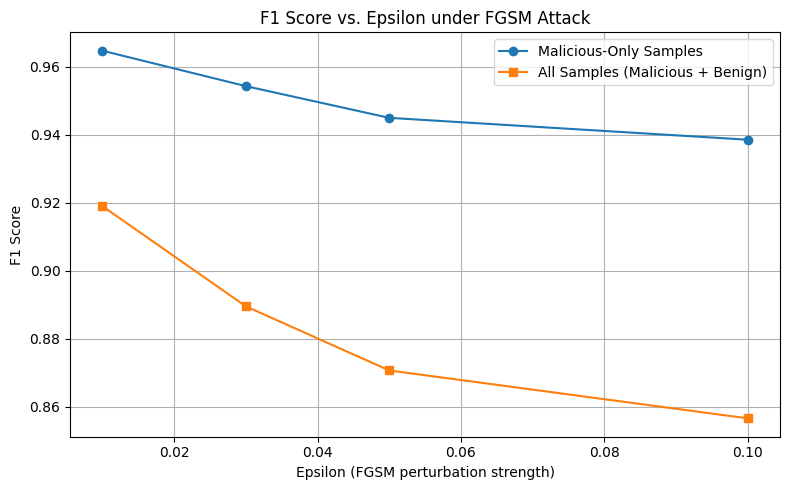

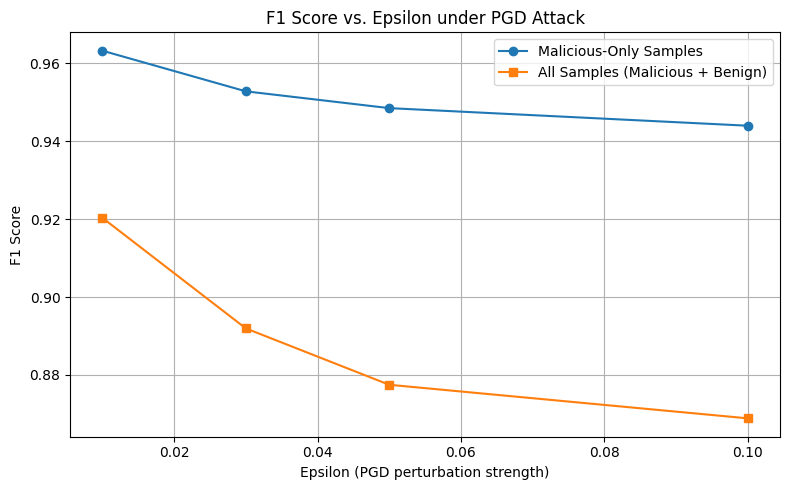

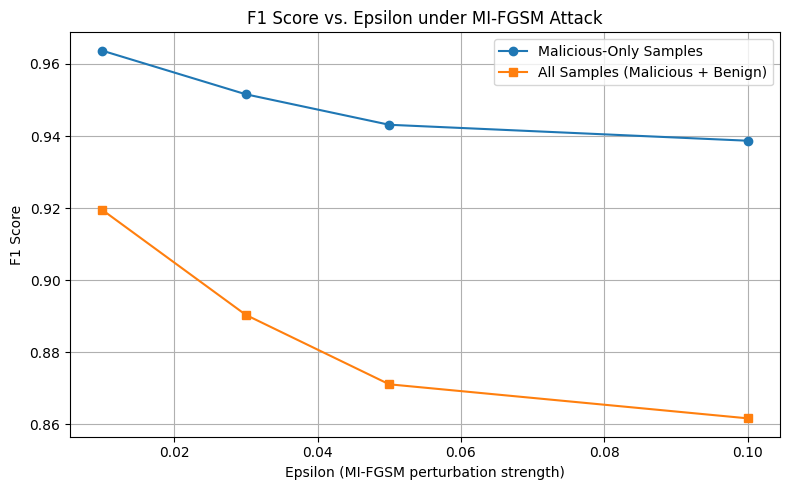

In [52]:
import matplotlib.pyplot as plt

def plot_results(f1_malicious_list, f1_all_list, epsilons, a_type="PGD"):
    plt.figure(figsize=(8, 5))
    plt.plot(epsilons, f1_malicious_list, marker='o', label='Malicious-Only Samples')
    plt.plot(epsilons, f1_all_list, marker='s', label='All Samples (Malicious + Benign)')
    plt.xlabel(f"Epsilon ({a_type} perturbation strength)")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Score vs. Epsilon under {a_type} Attack")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

f1_malicious_scores = [entry['adversarial']['f1'] for entry in fgsm_mal]
f1_all_scores = [entry['adversarial']['f1'] for entry in fgsm_full]
plot_results(f1_malicious_scores, f1_all_scores, epsilons=[0.01, 0.03, 0.05, 0.1], a_type='FGSM')


f1_malicious_scores_pgd = [entry['adversarial']['f1'] for entry in pgd_mal]
f1_all_scores_pgd = [entry['adversarial']['f1'] for entry in pgd_full]

plot_results(f1_malicious_scores_pgd, f1_all_scores_pgd, epsilons=[0.01, 0.03, 0.05, 0.1], a_type='PGD')

f1_malicious_scores_mi = [entry['adversarial']['f1'] for entry in mi_mal]
f1_all_scores_mi = [entry['adversarial']['f1'] for entry in mi_full]

plot_results(f1_malicious_scores_mi, f1_all_scores_mi, epsilons=[0.01, 0.03, 0.05, 0.1], a_type='MI-FGSM')

